In [9]:
import pickle as pk
import pandas as pd
from tqdm import tqdm
from pymatgen.core.structure import Structure, Molecule
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph
import numpy as np
from sklearn.model_selection import train_test_split
import random

In [2]:
data = pd.read_csv('data/data_all_new.csv')

molecules = []
targets = []

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    molecules.append(Molecule.from_str(row['xyz'], 'xyz'))
    targets.append(row['U_0'] / len(molecules[-1]))

100%|██████████| 122381/122381 [01:03<00:00, 1940.19it/s]


In [3]:
def create_structure_dict(structures: list, targets: list):
    structure_dict = {}

    for structure in tqdm(zip(structures, targets), total=len(structures)):
        if structure[0].formula in structure_dict:
            structure_dict[structure[0].formula].append(structure)
        else:
            structure_dict[structure[0].formula] = [structure]
        
    return structure_dict

def train_test_split_for_structures(structure_dict: dict, test_size: float = 0.1):
    structures_train, structures_test = [], []
    targets_train, targets_test = [], []
    train_all, test_all = [], []

    for _, data in tqdm(structure_dict.items()):
        if len(data) < 2:
            train_all += data
        else:
            train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
            train_all += train_data
            test_all += test_data
    
    random.shuffle(train_all)
    random.shuffle(test_all)

    for t_data in train_all:
        structures_train.append(t_data[0])
        targets_train.append(t_data[1])
    
    for te_data in test_all:
        structures_test.append(te_data[0])
        targets_test.append(te_data[1])
    
    return structures_train, targets_train, structures_test, targets_test

In [4]:
structure_dict = create_structure_dict(molecules, targets)

100%|██████████| 122381/122381 [00:14<00:00, 8483.11it/s]


In [5]:
molecules_train, targets_train, molecules_val_test, targets_val_test = train_test_split_for_structures(structure_dict)

100%|██████████| 134/134 [00:00<00:00, 2735.14it/s]


In [6]:
structure_dict_val_test = create_structure_dict(molecules_val_test, targets_val_test)

100%|██████████| 12293/12293 [00:01<00:00, 7889.91it/s]


In [7]:
molecules_val, targets_val, molecules_test, targets_test = train_test_split_for_structures(structure_dict_val_test, 0.5)

100%|██████████| 117/117 [00:00<00:00, 5585.79it/s]


In [8]:
from megnet.models import MEGNetModel
model = MEGNetModel.from_file("callback\\300+100e_64b_def_pa\\val_mae_00101_0.001756.hdf5")

d:\Projects\projects_python\m3gnet_tests\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [9]:
nfeat_bond = 10
r_cutoff = 5
gaussian_centers = np.linspace(0, r_cutoff + 1, nfeat_bond)
gaussian_width = 0.5
graph_converter = CrystalGraph(cutoff=r_cutoff)
model = MEGNetModel(graph_converter=graph_converter, centers=gaussian_centers, width=gaussian_width)


In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

loss_values = []

class LossHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_values.append(logs.get('loss'))

name = "400+100e_64b_def_pa"
log_dir = f"logs/fit/{name}"  # Путь для сохранения журналов TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq = 'epoch')

history = LossHistory()

model.train(train_structures=molecules_train,
            train_targets=targets_train,
            validation_structures=molecules_val,
            validation_targets=targets_val,
            epochs=100,
            dirname=f'callback/{name}',
            batch_size=64,
            callbacks=[history, tensorboard_callback])

Epoch 1/100
1721/1721 [==============================] - 253s 140ms/step - loss: 1.0698e-04
Epoch 2/100
1721/1721 [==============================] - 226s 132ms/step - loss: 6.8382e-05
Epoch 3/100
1721/1721 [==============================] - 217s 126ms/step - loss: 8.8705e-05
Epoch 4/100
1721/1721 [==============================] - 199s 116ms/step - loss: 1.0616e-04
Epoch 5/100
1721/1721 [==============================] - 200s 116ms/step - loss: 8.6310e-05
Epoch 6/100
1721/1721 [==============================] - 201s 117ms/step - loss: 8.3094e-05
Epoch 7/100
1721/1721 [==============================] - 201s 117ms/step - loss: 1.8899e-04
Epoch 8/100
1721/1721 [==============================] - 203s 118ms/step - loss: 4.8154e-05
Epoch 9/100
1721/1721 [==============================] - 203s 118ms/step - loss: 8.6461e-05
Epoch 10/100
1721/1721 [==============================] - 207s 120ms/step - loss: 1.0656e-04
Epoch 11/100
1721/1721 [==============================] - 207s 120ms/step - los

In [10]:
model.save_model(f'models/{name}.hdf5')

In [11]:
import os
import pickle

# Create the directory structure if it does not exist
os.makedirs('logs/lists/', exist_ok=True)

with open(f'logs/lists/{name}.pkl', 'wb') as f:
    pickle.dump(loss_values, f)

In [14]:
y_pred = np.array([])
y_true = np.array([])

for i in tqdm(range(len(molecules_test))):
    y_pred = np.append(y_pred, model.predict_structure(molecules_test[i])*len(molecules_test[i]))
    y_true = np.append(y_true, targets_test[i]*len(molecules_test[i]))
    if np.isneginf(y_pred[-1]):
        print(i, y_pred[-1], molecules_test[i])
mae = np.mean(np.abs(y_true - y_pred))
mae
#0.039550965940468794
#0.037391016147648025
#0.03080998909248267 - 0.002088
#0.02916814067862552 - 0.001992
#0.026491006478989467 - 0.001840
#0.025394472958211758 - 0.001756
#0.025353239192962555 - 0.001710

100%|██████████| 6153/6153 [07:35<00:00, 13.50it/s]


0.039550965940468794

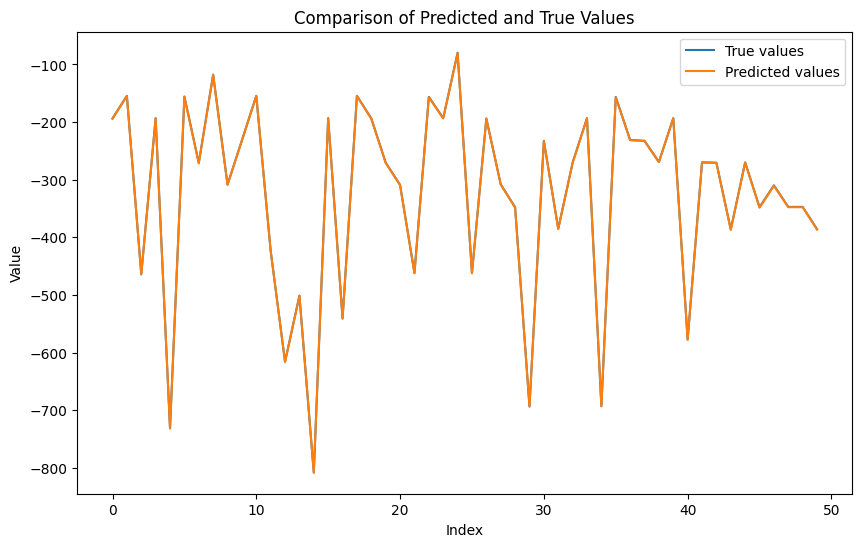

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_true[:50], label='True values')
plt.plot(y_pred[:50], label='Predicted values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Predicted and True Values')
plt.legend();

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, color='b', alpha=0.5, s=20) 
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='r', linestyle='--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs True Values')
plt.grid(True)

NameError: name 'y_true' is not defined

<Figure size 1000x600 with 0 Axes>

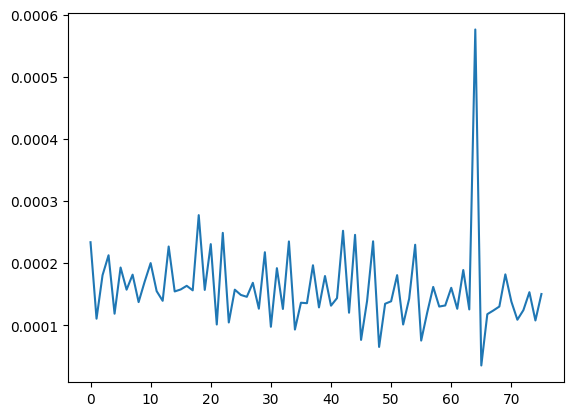

In [17]:
plt.plot(loss_values)